In [0]:
FN = 'predict'

In [0]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [0]:
import keras
keras.__version__

'2.1.6'

In [0]:
FN0 = 'json_news-5000-glove-vocab-embedding'

In [0]:
FN1 = 'train-5000-2'

In [0]:
nb_train_samples = 5000
nb_val_samples = 50

In [0]:
maxlend = 75 # 0 - if we dont want to use description at all
maxlenh = 16
maxlen = maxlend + maxlenh
rnn_size = 64
rnn_layers = 2  # match FN1
# rnn_layers = 3
batch_norm = False

In [0]:
activation_rnn_size = 40 if maxlend else 0

lambda_dim = 2*(rnn_size - activation_rnn_size)

In [0]:
# training parameters
seed = 42
p_W, p_U, p_dense, weight_decay = 0, 0, 0, 0
optimizer = 'rmsprop'
batch_size=64

In [0]:
import pickle

with open('pickles/%s.pickle'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [0]:
nb_unknown_words = 10

In [0]:
print('dimension of embedding space for words',embedding_size)
print('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print('total number of different words',len(idx2word), len(word2idx))
print('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

dimension of embedding space for words 100
vocabulary size 39453 the last 10 words can be used as place holders for unknown/oov words
total number of different words 39455 39455
number of words outside vocabulary which we can substitue using glove similarity 8890
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) -8888


In [0]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [0]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [0]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [0]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [0]:
def prt(label, x):
    print(label+':'),
    for w in x:
        print(idx2word[w]),
    print

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers.core import Lambda
import keras.backend as K
K.backend()

'tensorflow'

In [0]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [0]:
regularizer = l2(weight_decay) if weight_decay else None

In [0]:
rnn_model = Sequential()
# from keras.layers import InputLayer
# model_input = InputLayer(input_shape=(maxlen,))
# rnn_model.add(model_input)
# rnn_model.output.tag.test_value = np.random.randint(vocab_size,size=(batch_size,maxlen)).astype('float32')
rnn_model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
#                         batch_input_shape=(batch_size,maxlen),
                        embeddings_regularizer=regularizer, weights=[embedding], mask_zero=True,
                        name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                kernel_regularizer=regularizer, recurrent_regularizer=regularizer,
                bias_regularizer=regularizer, dropout=p_W, recurrent_dropout=p_U,
                name='lstm_%d'%(i+1)
                  )
    rnn_model.add(lstm)
    rnn_model.add(Dropout(p_dense, name='dropout_%d'%(i+1)))

In [0]:
rnn_model.load_weights('pickles/train-weights-lines_5000-iter_100-layers_2_iter100.hdf5',by_name=True)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 91, 100)           3945300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 91, 64)            42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 91, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 91, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 91, 64)            0         
Total params: 4,020,564
Trainable params: 4,020,564
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(rnn_model.layers[0].get_weights())

[array([[-0.1773875 ,  0.6372642 ,  0.32801583, ..., -0.10244963,
        -0.67100906, -0.55440164],
       [-0.89117724,  0.42207116, -0.25733128, ...,  0.6377615 ,
         0.6397168 ,  0.3933113 ],
       [-0.04279218, -0.21113484,  0.7327986 , ..., -0.15707017,
         0.8271285 ,  0.25070208],
       ...,
       [ 0.48706606,  0.6691793 , -0.0882058 , ...,  0.3558768 ,
        -0.14876254, -0.14990547],
       [-0.67171794, -0.09513056, -0.6988457 , ..., -0.25448114,
         0.50731444,  0.42698762],
       [-0.50040406,  0.13563907, -0.3586453 , ..., -0.64897496,
        -0.3132541 , -0.43104267]], dtype=float32)]


In [0]:
import h5py
with h5py.File('pickles/train-weights-lines_5000-iter_100-layers_2_iter100.hdf5', mode='r') as f:
    if 'layer_names' not in f.attrs and 'model_weights' in f:
        f = f['model_weights']
    weights = [np.copy(v) for v in f['time_distributed_1']['time_distributed_1'].values()]

In [0]:
# kernel, bias
weights = np.array([weights[1], weights[0]])
list(map(lambda x: x.shape, weights))

[(48, 39453), (39453,)]

In [0]:
def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    print(type(mask))
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))

In [0]:
model = Sequential()
model.add(rnn_model)
model.summary()
if activation_rnn_size:
    model.add(Lambda(simple_context,
                     mask = lambda inputs, mask: mask[:,maxlend:],
                     output_shape = lambda input_shape: (input_shape[0], maxlenh, lambda_dim),
                     name='simplecontext_1'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 91, 64)            4020564   
Total params: 4,020,564
Trainable params: 4,020,564
Non-trainable params: 0
_________________________________________________________________
<class 'tensorflow.python.framework.ops.Tensor'>


In [0]:
lambda_dim

48

In [0]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
n = lambda_dim
n

48

In [0]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [0]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [0]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [0]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
print(samples)
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
print(data)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [0]:
np.all(data[:,maxlend] == eos)

True

In [0]:
data.shape,list(map(len, samples))

((1, 91), [76])

In [0]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 16, 48)

In [0]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [0]:
# !pip install python-Levenshtein

In [0]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [0]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < vocab_size-nb_unknown_words else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= vocab_size-nb_unknown_words])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [0]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [0]:
import sys
import Levenshtein

def gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print('HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i]))
        print('DESC:',' '.join(idx2word[w] for w in X_test[i]))
        sys.stdout.flush()
        x = X_test[i]
    else:
        for w in X.split():
            w = w.rstrip('^')
            if not w in word2idx:
                word2idx[w] = word2idx.get(w, len(word2idx))

        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indicies
        if isinstance(avoid,str) or isinstance(avoid[0], int) or isinstance(avoid[0], np.int64):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) or isinstance(w,np.int64) else word2idx[w] for w in a])
                 for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples

In [0]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [0]:
# X = "* Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing"
# Y = "Billy Joel Lists in Sagaponack^"

In [0]:
data_file  = 'pickles/json_news_5000.pickle'

In [0]:
# Read from eval pickle file
import pickle
import csv
from nltk.translate.bleu_score import sentence_bleu

#rouge = Rouge()

with open(data_file, 'rb') as fp:
    df = pickle.load(fp) # keywords are not used in this project
    heads = df['title'].tolist()[:10]
    desc = df['content'].tolist()[:10]

with open('5k-2-eval.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Reference', 'Description', 'Generated', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])

    for i in range(len(heads)):
        Y = heads[i][0]
        X = desc[i][0]

        print('HEAD: ', Y)
        try:
            samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)
            reference = [Y.split()]

            headline = samples[0][0][len(samples[0][1]):]

            candidate = [idx2word[w] for w in headline]
            candidate = candidate[:len(candidate)-1]
            head_str = ' '.join(idx2word[w] for w in headline[:len(headline)-1])

            # BLEU score
            bleu1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
            bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
            bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
            bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
            print('Cumulative 1-gram: %f' % bleu1)
            print('Cumulative 2-gram: %f' % bleu2)
            print('Cumulative 3-gram: %f' % bleu3)
            print('Cumulative 4-gram: %f' % bleu4)

            writer.writerow([Y, X, head_str, bleu1, bleu2, bleu3, bleu4])
        except:
            print('Failed to generate headlines.')
            writer.writerow([Y, X, 'N/A', 0, 0, 0, 0])


HEAD:  Worcester breakfast club for veteran give hunger it marching order
HEADS:
2.8008017539978027 
9.256567478179932 ago
34.395591497421265 fed more suri say
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Jumpshot Gives Marketers Renewed Visibility Into Paid and Organic Keywords With Launch of Jumpshot Elite
HEADS:
54.79575490951538 pacific link sept to per to announced
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  The Return Of The Nike Air Max Sensation Has 80 s Babies Hyped
HEADS:
128.1415295600891 33 alarm taking moves fifth keeper council moped rat rise threats express couldn
142.07769012451172 increase in 23 legal million baby of lock commander 2016 rate steal fremantle labor potential fisherman
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  This New Dating App Wil

/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


3.2151777744293213 
10.338221788406372 season
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Hands on with Apple s iPhone 6 iPad Pro and Apple TV
HEADS:
11.456171751022339 austin
13.20128345489502 northwest
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Harwood Feffer LLP Announces Investigation of VASCO Data Security International Inc
HEADS:
64.84104442596436 opening subscriptions leadership 2006 share you completely
68.19050002098083 and cash due operation safety name ever is
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  What will happen to Peta Credlin and Brian Loughnane Liberal power couple
HEADS:
9.387882232666016 from
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000


In [0]:
X = "This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     During his first press conference in several months,   Donald Trump vehemently denied Tuesday‚Äôs reports alleging that Russia had compromising information about him, calling it ‚Äúfake news. ‚Äù Trump also announced that his sons will take over the Trump Organization once he becomes president, a move ethics experts say doesn‚Äôt satisfy    concerns and Trump again refused to release his tax returns, saying ‚Äúthe only ones who care about my tax returns are reporters. ‚Äù Representative John Lewis and Senator Corey Booker testified against Senator Jeff Sessions during the second day of his Senate confirmation hearing to serve as U. S. attorney general. Rex Tillerson, Trump‚Äôs choice for secretary of state, was critical of Russia during his hearing, saying the country ‚Äúposes a danger‚Äù to the United States and transportation secretary nominee Elaine Chao said she hopes to ‚Äúunleash the potential‚Äù of private investment for federal infrastructure projects. Seek the Truth: ‚ÄúBuzzFeed‚Äôs decision to publish a dossier full of serious accusations against   Donald Trump on Tuesday raised serious questions,‚Äù writes David A. Graham, one of which concerns the journalism ethics of publishing a document full of unverified claims. A Plan in Jeopardy?: Republicans are facing a number of obstacles in their quest to repeal the Affordable Care Act, such as finding a suitable alternative that won‚Äôt leave millions of Americans without insurance. Still, the GOP is moving forward with its plan"# ‚Äî  for now. (Russell Berman) Divided We Fall: Trump‚Äôs critics will need to come together to minimize the damage they fear he will impose, argues Conor Friedersdorf. ‚ÄúYet large swaths of the right and left, including extremely thoughtful,   observers of the American scene, are behaving as if such cooperation is impossible. ‚Äù Why? Follow stories throughout the day with our Politics  Policy portal. More on Trump‚Äôs Business Plans: The   says he will turn all business operations over to his two sons once he assumes the presidency and won‚Äôt enter into any new deals with international partners. But ethics experts say Trump is still facing ‚Äúa constitutional crisis. ‚Äù (Maggie Haberman, Julie Hirschfeld Davis, and Eric Lipton, The New York Times) On the Defense: The cyber hack on the Democratic Party was instigated by an ‚Äúelite‚Äù unit of hackers ‚Äúlinked to the Russian military intelligence service, known as the GRU, and its targets span the globe and parallel the interests of the Russian state. ‚Äù The party never stood a chance against them. (Tim Johnson, McClatchy DC) A Look Inside: Marie Claire spoke with former ‚Äúskin chicks,‚Äù female members of the white supremacist movement. While the cause is   feelings of rage and a desire for community may be contributing to a growing number of women joining the movement. (Kate Storey) Thanks, Obama: Although reviews of his presidency will be mixed, writes Ezra Klein, Americans will miss several things about Barack Obama, namely ‚Äúhis decency. His   administration. The seriousness with which he approached his job. The faith he had in the American political system, and in Americans. ‚Äù (Vox) Solving a Mystery: Raheel Siddiqui, a Muslim Marine recruit, fell to his death during basic training in Parris Island, South Carolina, in March 2016. The Marine Corps ruled the death a suicide, but Siddiqui‚Äôs family thinks differently. Did a night of hazing go wrong? (Alex French, Esquire)   Before and After: Serving as commander in chief of the United States has taken a visible toll on President Obama. Click on these images to see how the president has aged over the past eight years. (Alan Taylor, The Atlantic) Senate confirmation hearings for   Trump‚Äôs Cabinet nominees began on Tuesday. What‚Äôs the one question you‚Äôd be afraid to answer honestly at your own confirmation hearing? Send your answers to hello@theatlantic. com, and our favorites will be featured in Friday‚Äôs Politics  Policy Daily.   by Elaine Godfrey (@elainejgodfrey) and Candice Norwood (@cjnorwoodwrites)""
Y = "The Atlantic  Politics & Policy Daily: Back-to-Back Sessions"

In [0]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
44.14431929588318 center global is camp sept to


In [0]:
X = "18 Cake GIFs That 'll Make You Moist"
Y = "Is it 350degF^ in here or is it just me ?"

In [0]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
20.307226181030273 stake on
36.96908521652222 park corporation 6 4


In [0]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [0]:
gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
3.6473581790924072 
14.61897349357605 new for
19.983611822128296 new for on
22.538193941116333 new for owner
24.320326805114746 stream 2015 b
25.679430961608887 stream 2015 increased
28.41639542579651 new for on 34
28.72929072380066 new for on follow
30.03572654724121 stream 2015 b new
31.766599893569946 new for on during to
38.62402892112732 stream 2015 b new flood
40.249629974365234 new for on during to man
47.04489350318909 stream 2015 b new by with be
74.07227563858032 new for on during to man concord wish in alamos
87.7929995059967 stream 2015 b new by with be september alexa fuel is hits
93.16409015655518 stream 2015 b new by with be september alexa fuel is hits with
112.76234197616577 stream 2015 b new by with be september alexa fuel is hits with with cut blatter
113.71352529525757 stream 2015 b new by with be september alexa fuel is hits with with cut yardley
113.98764848709106 stream 2015 b new by with be september alexa fuel is hits with with cut doorview
130.992315769

In [0]:
X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [0]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1)

HEADS:
16.336666584014893 of music


In [0]:
headline = samples[0][0][len(samples[0][1]):]

In [0]:
' '.join(idx2word[w] for w in headline)

'of music ~'

In [0]:
avoid = headline

In [0]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
14.983952617645263 the off


In [0]:
avoid = samples[0][0][len(samples[0][1]):]

In [0]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
13.506104564666748 s in


In [0]:
len(samples)

20

In [0]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    #assert mask.ndim == 2
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    #eturn activation_weights
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))

class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = lambda_dim
        return (nb_samples, maxlenh, n)

In [0]:
wmodel = Sequential()
wmodel.add(rnn_model)

In [0]:
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 91, 100)           3945300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 91, 64)            42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 91, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 91, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 91, 64)            0         
Total params: 4,020,564
Trainable params: 4,020,564
Non-trainable params: 0
_________________________________________________________________


In [0]:
wmodel.add(Lambda(simple_context,
                 mask = lambda inputs, mask: mask[:,maxlend:],
                 output_shape = lambda input_shape: (input_shape[0], maxlenh, lambda_dim)))

<class 'tensorflow.python.framework.ops.Tensor'>


In [0]:
wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [0]:
X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [0]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
6.27395486831665 
16.794414043426514 to and in


In [0]:
sample = samples[0][0]

In [0]:
' '.join([idx2word[w] for w in sample])

'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ <2>^ have you been listening to this year <3>^ <4>^ you want to find out using cold <6>^ hard evidence <6>^ then <7>^ <0>^ new <8>^ in <9>^ tool will tell you <1>^ ~ ~'

In [0]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 91)

In [0]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

(1, 16, 48)

In [0]:
startd = np.where(data[0,:] != empty)[0][0]
try:
    lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
except:
    print('No EOS in data[0,maxlend+1:], using data[0,maxlend+1:].shape[0] instead')
    lenh = data[0, maxlend+1:].shape[0]
startd, lenh

(42, 0)

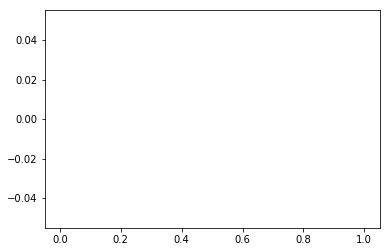

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [0]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [0]:
heat(sample, weights[0,-1])